# 1. Install Dependencies and Setup

In [1]:
print("Hello, world!")

Hello, world!


In [2]:
import tensorflow as tf
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
imgsize = 1024
batchsize = 16
data_dir = 'data2'

# 3. Load Data

In [6]:
data = tf.keras.utils.image_dataset_from_directory(data_dir, batch_size=batchsize, image_size=(imgsize, imgsize))

Found 973 files belonging to 2 classes.


----- Remainder is Optional -----

In [ ]:
data_iterator = data.as_numpy_iterator()

In [ ]:
batch = data_iterator.next()

In [ ]:
batch[0].shape

In [ ]:
fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for idx, img in enumerate(batch[0][:5]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [7]:
data = data.map(lambda x,y: (x/255, y))

# 5. Split Data

In [8]:
len(data)

61

In [9]:
train_size = int(len(data)*.7)+1
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [10]:
train_size

43

In [11]:
val_size

12

In [12]:
test_size

6

In [13]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [15]:
model = Sequential()

In [16]:
model.add(Conv2D(32, (7,7), 1, activation='relu', input_shape=(imgsize,imgsize,3)))
model.add(MaxPooling2D())

model.add(Conv2D(64, (5,5), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(128, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(256, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [17]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1018, 1018, 32)    4736      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 509, 509, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 505, 505, 64)      51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 252, 252, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 250, 250, 128)     73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 125, 125, 128)    0

# 7. Train

In [19]:
logdir='logs'

In [20]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [21]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
43/43 [==============================] - 32s 351ms/step - loss: 1.8089 - accuracy: 0.5785 - val_loss: 0.5583 - val_accuracy: 0.6771
Epoch 2/20
43/43 [==============================] - 16s 361ms/step - loss: 0.7342 - accuracy: 0.6395 - val_loss: 0.5856 - val_accuracy: 0.6615
Epoch 3/20
43/43 [==============================] - 16s 365ms/step - loss: 0.5033 - accuracy: 0.7587 - val_loss: 0.4339 - val_accuracy: 0.8229
Epoch 4/20
43/43 [==============================] - 16s 361ms/step - loss: 0.5401 - accuracy: 0.8052 - val_loss: 0.4775 - val_accuracy: 0.7865
Epoch 5/20
43/43 [==============================] - 16s 359ms/step - loss: 0.3587 - accuracy: 0.8910 - val_loss: 0.5244 - val_accuracy: 0.8281
Epoch 6/20
43/43 [==============================] - 17s 396ms/step - loss: 0.2183 - accuracy: 0.9142 - val_loss: 0.3301 - val_accuracy: 0.8594
Epoch 7/20
43/43 [==============================] - 16s 366ms/step - loss: 0.2441 - accuracy: 0.9186 - val_loss: 0.6691 - val_accuracy: 0.7604

# 8. Plot Performance

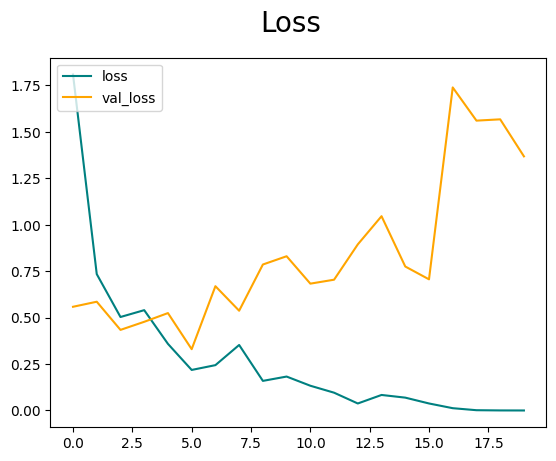

In [22]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

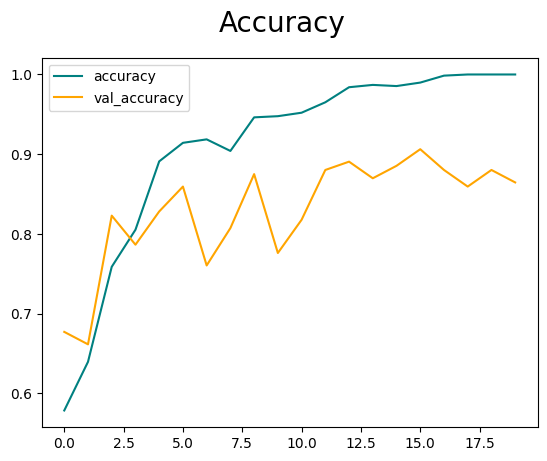

In [23]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [24]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [25]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [26]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [27]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.82978725, shape=(), dtype=float32) tf.Tensor(0.8125, shape=(), dtype=float32) tf.Tensor(0.81330127, shape=(), dtype=float32)


# 10. Test

In [47]:
img0 = cv2.imread('test/897.jpg')
img1 = cv2.imread('test/1253.jpg')
img2 = cv2.imread('test/1254.jpg')
img3 = cv2.imread('test/1305.jpg')
img4 = cv2.imread('test/1470.jpg')

img5 = cv2.imread('test/1547.jpg')
img6 = cv2.imread('test/1430.jpg')
img7 = cv2.imread('test/1431.jpg')
img8 = cv2.imread('test/1466.jpg')
img9 = cv2.imread('test/1515.jpg')
#plt.imshow(cv2.cvtColor(img0, cv2.COLOR_BGR2RGB))
#plt.show()

In [48]:
resize0 = tf.image.resize(img0, (imgsize,imgsize))
resize1 = tf.image.resize(img1, (imgsize,imgsize))
resize2 = tf.image.resize(img2, (imgsize,imgsize))
resize3 = tf.image.resize(img3, (imgsize,imgsize))
resize4 = tf.image.resize(img4, (imgsize,imgsize))

resize5 = tf.image.resize(img5, (imgsize,imgsize))
resize6 = tf.image.resize(img6, (imgsize,imgsize))
resize7 = tf.image.resize(img7, (imgsize,imgsize))
resize8 = tf.image.resize(img8, (imgsize,imgsize))
resize9 = tf.image.resize(img9, (imgsize,imgsize))
#plt.imshow(resize0.numpy().astype(int))
#plt.show()

In [31]:
#yhat0 = model.predict(np.expand_dims(resize0/255, 0))
yhat0 = model.predict(np.expand_dims(resize0/255, 0))[0][0]
yhat1 = model.predict(np.expand_dims(resize1/255, 0))[0][0]
yhat2 = model.predict(np.expand_dims(resize2/255, 0))[0][0]
yhat3 = model.predict(np.expand_dims(resize3/255, 0))[0][0]
yhat4 = model.predict(np.expand_dims(resize4/255, 0))[0][0]

yhat5 = model.predict(np.expand_dims(resize5/255, 0))[0][0]
yhat6 = model.predict(np.expand_dims(resize6/255, 0))[0][0]
yhat7 = model.predict(np.expand_dims(resize7/255, 0))[0][0]
yhat8 = model.predict(np.expand_dims(resize8/255, 0))[0][0]
yhat9 = model.predict(np.expand_dims(resize9/255, 0))[0][0]

In [46]:
# should be 1
print("{:.11f}".format(yhat0), " - Want 1.0")
print("{:.11f}".format(yhat1), " - Want 1.0")
print("{:.11f}".format(yhat2), " - Want 1.0")
print("{:.11f}".format(yhat3), " - Want 1.0")
print("{:.11f}".format(yhat4), " - Want 1.0")
print("------------------------")
print("{:.11f}".format(yhat5), " - Want 0.0")
print("{:.11f}".format(yhat6), " - Want 0.0")
print("{:.11f}".format(yhat7), " - Want 0.0")
print("{:.11f}".format(yhat8), " - Want 0.0")
print("{:.11f}".format(yhat9), " - Want 0.0")

0.03099621087  - Want 1.0
0.31958216429  - Want 1.0
0.84896820784  - Want 1.0
0.99926871061  - Want 1.0
0.99999880791  - Want 1.0
------------------------
0.11162064224  - Want 0.0
0.00000000000  - Want 0.0
0.00000000000  - Want 0.0
0.99999499321  - Want 0.0
0.00000115958  - Want 0.0


# 11. Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','imageclassifier.h5'))

In [ ]:
new_model = load_model(os.path.join('models', 'imageclassifier.h5'))

In [ ]:
yhatnew = new_model.predict(np.expand_dims(resize0/255, 0))

In [ ]:
yhatnew

# 12. Release Memory

In [49]:
from keras import backend as kbe
kbe.clear_session()

In [50]:
from numba import cuda
cuda.select_device(0)
cuda.close()